# Reading the dataset

In [1]:
import pandas as pd
import numpy as np
# read the data
df1 = pd.read_csv('./LUFlow-master/2022/06/2022.06.12/2022.06.12.csv')
df2 = pd.read_csv('./LUFlow-master/2022/06/2022.06.13/2022.06.13.csv')
df3 = pd.read_csv('./LUFlow-master/2022/06/2022.06.14/2022.06.14.csv')

# Merging into 1 dataframe

In [2]:
df_dataset = pd.concat([df1, df2, df3])
df_dataset.reset_index(drop=True, inplace=True)
print(df_dataset)

         avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  \
0            0.0         0          0      786    31306.0  0.000000   
1            0.0         0          0      786    24298.0  0.000000   
2            0.0         0          0      786    31789.0  0.000000   
3            0.0         0          0      786    29409.0  0.000000   
4            0.0         0          0      786    60965.0  0.000000   
...          ...       ...        ...      ...        ...       ...   
1068371      0.0         8          8      786        NaN  2.750000   
1068372      0.0         8          8      786        NaN  3.000000   
1068373    144.5        12         12      786     5900.0  2.886842   
1068374     20.0         7          0      786       23.0  2.807355   
1068375      0.0         8          8      786        NaN  2.750000   

         num_pkts_out  num_pkts_in  proto  src_ip  src_port          time_end  \
0                   1            0      6     786   47613.0  16550

# Displaying the data

In [3]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068376 entries, 0 to 1068375
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   avg_ipt        1068376 non-null  float64
 1   bytes_in       1068376 non-null  int64  
 2   bytes_out      1068376 non-null  int64  
 3   dest_ip        1068376 non-null  int64  
 4   dest_port      964168 non-null   float64
 5   entropy        1068376 non-null  float64
 6   num_pkts_out   1068376 non-null  int64  
 7   num_pkts_in    1068376 non-null  int64  
 8   proto          1068376 non-null  int64  
 9   src_ip         1068376 non-null  int64  
 10  src_port       964168 non-null   float64
 11  time_end       1068376 non-null  int64  
 12  time_start     1068376 non-null  int64  
 13  total_entropy  1068376 non-null  float64
 14  label          1068376 non-null  object 
 15  duration       1068376 non-null  float64
dtypes: float64(6), int64(9), object(1)
memory usage: 130.4

In [4]:
df_dataset = df_dataset.drop(['time_start', 'time_end', 'dest_ip', 'src_ip'], axis=1)

# Taking care of missing data, Removing duplicates

In [5]:
# replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# drop missing values
df_dataset.dropna(inplace=True)

In [7]:
print(df_dataset.duplicated().sum())

105388


In [8]:
df_dataset.drop_duplicates(inplace = True)

In [9]:
print(df_dataset.duplicated().sum())

0


# Implementing binary classification

In [10]:
df_dataset["label"].value_counts()

label
benign       434553
outlier      352045
malicious     72182
Name: count, dtype: int64

In [11]:
old_value = 'outlier'
new_value = 'malicious'
df_dataset['label'] = df_dataset['label'].replace(old_value, new_value)

In [12]:
old_value = 'malicious'
new_value = 1
df_dataset['label'] = df_dataset['label'].replace(old_value, new_value)

In [13]:
old_value = 'benign'
new_value = 0
df_dataset['label'] = df_dataset['label'].replace(old_value, new_value)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7824\1413564682.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset['label'] = df_dataset['label'].replace(old_value, new_value)


In [14]:
df_dataset["label"].value_counts()

label
0    434553
1    424227
Name: count, dtype: int64

# Balancing the data (Undersampling)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
df_equal = df_dataset

# Creating train/test split

In [16]:
train, test = train_test_split(df_equal, test_size=0.2)

In [17]:
# display columns
train.columns

Index(['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
       'num_pkts_out', 'num_pkts_in', 'proto', 'src_port', 'total_entropy',
       'label', 'duration'],
      dtype='object')

In [18]:
# feature info
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687024 entries, 829073 to 772750
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        687024 non-null  float64
 1   bytes_in       687024 non-null  int64  
 2   bytes_out      687024 non-null  int64  
 3   dest_port      687024 non-null  float64
 4   entropy        687024 non-null  float64
 5   num_pkts_out   687024 non-null  int64  
 6   num_pkts_in    687024 non-null  int64  
 7   proto          687024 non-null  int64  
 8   src_port       687024 non-null  float64
 9   total_entropy  687024 non-null  float64
 10  label          687024 non-null  int64  
 11  duration       687024 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 68.1 MB


# Feature scaling

In [19]:
min_max_scaler = MinMaxScaler().fit(train[['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
                                           'num_pkts_out', 'num_pkts_in', 'src_port',
                                           'total_entropy', 'duration']])

In [20]:
numerical_columns = ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
                     'num_pkts_out', 'num_pkts_in', 'src_port',
                    'total_entropy', 'duration']

In [21]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [22]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

# Counting number of records in each split

In [23]:
print("Full dataset:\n")
print("Benign: " + str(df_equal["label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_equal["label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 434553
Malicious: 424227
---------------
Training set:

Benign: 347503
Malicious: 339521
---------------
Test set:

Benign: 87050
Malicious: 84706


# Creating X, y variables

In [24]:
y_train = np.array(train.pop("label"))# pop removes "Label" from the dataframe
X_train = train.values

In [25]:
y_test = np.array(test.pop("label")) # pop removes "Label" from the dataframe
X_test = test.values

# Kmeans Clustering

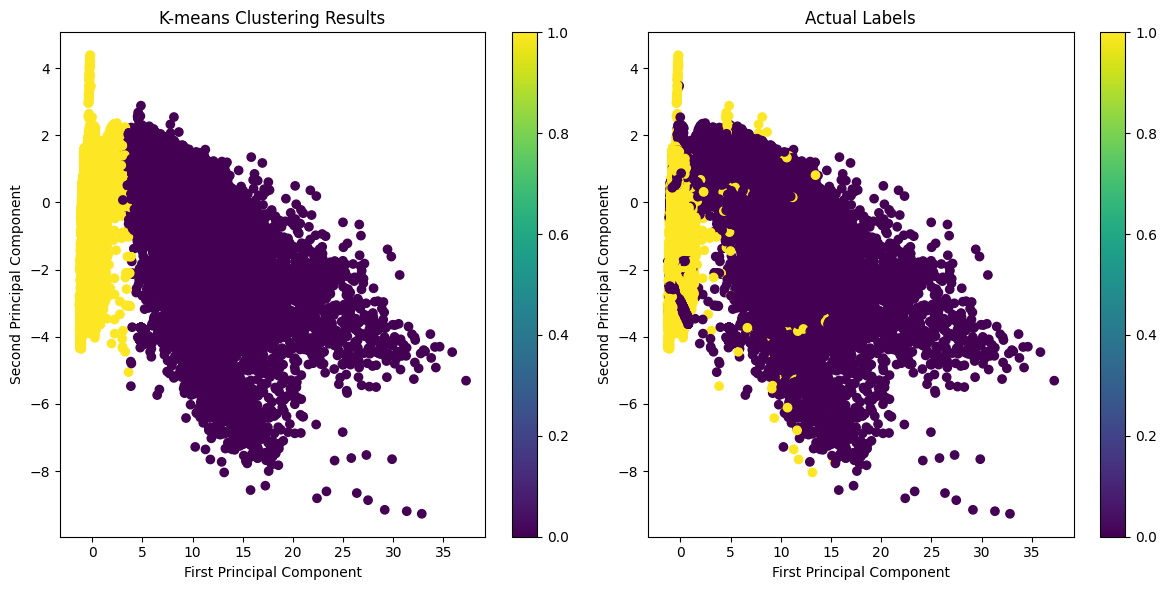

Clustering accuracy: 0.54

Feature Importance:
num_pkts_out: 0.4510
num_pkts_in: 0.4498
bytes_in: 0.4037
bytes_out: 0.3542
duration: 0.3247
entropy: 0.0780
total_entropy: 0.0666
dest_port: -0.0454
src_port: -0.0212
avg_ipt: 0.0067


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use PCA to dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(12, 6))

plt.subplot(121)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

plt.subplot(122)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title('Actual Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

accuracy = np.mean(cluster_labels == y_train)
print(f"Clustering accuracy: {accuracy:.2f}")

# Feature importance
feature_importance = pca.components_[0]
feature_names = ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
                 'num_pkts_out', 'num_pkts_in', 'src_port',
                 'total_entropy', 'duration']

print("\nFeature Importance:")
for name, importance in sorted(zip(feature_names, feature_importance), key=lambda x: abs(x[1]), reverse=True):
    print(f"{name}: {importance:.4f}")

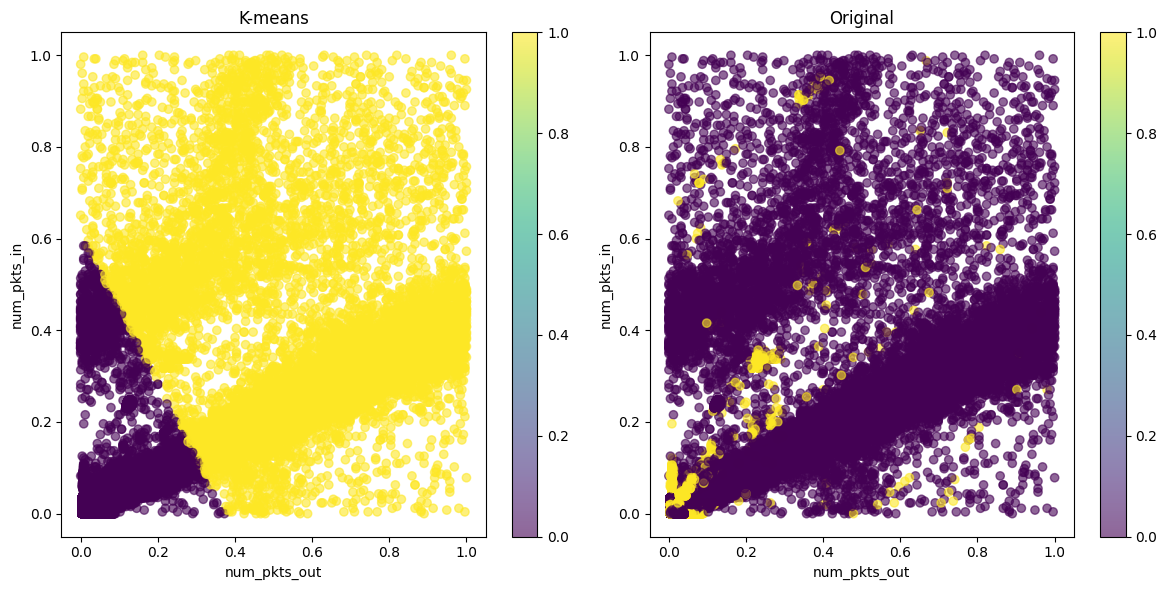

In [27]:
# Use the two most important features
feature_indices = [df_dataset.columns.get_loc('num_pkts_out'), df_dataset.columns.get_loc('num_pkts_in')]
X_top_two = X_train[:, feature_indices]

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_top_two)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_top_two[:, 0], X_top_two[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('num_pkts_out')
plt.ylabel('num_pkts_in')
plt.title('K-means')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_top_two[:, 0], X_top_two[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('num_pkts_out')
plt.ylabel('num_pkts_in')
plt.title('Original')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

In [28]:
accuracy = np.mean(cluster_labels == y_train)
print(f"Clustering accuracy: {accuracy:.2f}")

Clustering accuracy: 0.48
